## PLS  Base  on pre model

In [2]:
from hmmlearn import hmm
import glob
import os
from numpy import load
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy, deepcopy
from statistics import mean
from mlxtend.evaluate import permutation_test
from nilearn import plotting
import nilearn
from statsmodels.stats.multitest import multipletests
from statsmodels.multivariate.manova import MANOVA
import pingouin as pg
from sklearn.model_selection import LeaveOneOut
from copy import copy
from tqdm import tqdm
import pickle
from pyentrp import entropy as ent
import scipy.stats as stats
from scipy.stats import zscore
from itertools import groupby
from statistics import mean
from pyls import meancentered_pls


/home/jarvis/.local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/home/jarvis/miniconda3/envs/hmm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/jarvis/miniconda3/envs/hmm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.


In [3]:
sns.set_context("notebook", font_scale=1.5)

In [4]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

In [5]:
dirpath = '/home/jarvis/Documentos/catalina/hmm/TIME_SERIES/'
subjects = [os.path.basename(x) for x in glob.glob(dirpath + '*sub*')]
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ', 'ses-fro' ]

parcel="_mask_Schaefer2018_400_17N_MNI152_2mm_mask_file_..input..data..Schaefer2018_400_17N_MNI152_2mm.nii.gz"

In [6]:
scaler = StandardScaler()
schafer_file = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_Centroid_RAS.csv'
schafer = pd.read_csv(schafer_file, header=None, skiprows=[0,1])
schafer['network'] = schafer[1].str.split('_').str.get(2)
schafer['network_id'] = schafer.network.astype("category").cat.codes
schafer_image = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_MNI152_2mm.nii'

In [7]:
def get_time_series_network(dirpath, subects, stimulus, scan, parcel):
    
    subject_list = []
    series_array = []
    
    for subject in subjects:
        file_path = f'{dirpath}/{subject}/{stimulus}/roi_timeseries_0/{scan}/_compcor_ncomponents_5_selector_pc10.linear1.wm1.global0.motion1.quadratic1.gm0.compcor1.csf1/_bandpass_freqs_0.01.0.1/{parcel}/roi_stats.csv'
        series = pd.read_csv(file_path, skiprows=[0,1], header=None, delimiter='\t')
        scaled_series = series.apply(zscore)
        scaled_series = scaled_series.T
        scaled_series['network'] = schafer['network']
        series_average = scaled_series.groupby('network').mean()
        series_average = series_average.drop("Limbic", axis=0)
        
        series_array.append(series_average.T)
    return series_array

In [8]:
def get_time_series_all(dirpath, subects, stimulus, scan, parcel):
    
    subject_list = []
    series_array = []
    
    for subject in subjects:
        file_path = f'{dirpath}/{subject}/{stimulus}/roi_timeseries_0/{scan}/_compcor_ncomponents_5_selector_pc10.linear1.wm1.global0.motion1.quadratic1.gm0.compcor1.csf1/_bandpass_freqs_0.01.0.1/{parcel}/roi_stats.csv'
        series = pd.read_csv(file_path, skiprows=[0,1], header=None, delimiter='\t')
        scaled_series = series.T
        scaled_series['network'] = schafer['network']
        scaled_series.drop(scaled_series.index[scaled_series['network'] == 'Limbic'], inplace=True)
        del scaled_series['network']
        series_array.append(scaled_series.values.T)
    return series_array

In [9]:
def get_all_data_networks(scans, stimuli,subjects, dirpath, parcel): 
    
    scans_arrray = []
    
    for scan in scans:
        all_stimulus_array = []
        
        for stimulus in stimuli:
            stimulus_array = get_time_series(dirpath, subjects, stimulus, scan, parcel)
            all_stimulus_array.extend(stimulus_array)
    scans_arrray.extend(all_stimulus_array)
            
    return scans_arrray

In [10]:
def get_all_data(scans, stimuli,subjects, dirpath, parcel): 
    
    scans_arrray = []
    
    for scan in scans:
        all_stimulus_array = []
        
        for stimulus in stimuli:
            stimulus_array = get_time_series_all(dirpath, subjects, stimulus, scan, parcel)
            all_stimulus_array.extend(stimulus_array)
    scans_arrray.extend(all_stimulus_array)
            
    return scans_arrray

In [11]:
def fit_multiple_init(hmm_model, X, lenghts, n_rep=20):
    hmm_all = []
    scores_all = []

    for i in tqdm(range(n_rep)):
        hmm_m = copy(hmm_model)
        hmm_m.fit(X, lenghts)
        scores_all.append(hmm_m.score(X, lenghts))
        hmm_all.append(hmm_m)
         
    max_index = scores_all.index(max(scores_all))
    hmm_f_model = hmm_all[max_index]
    
    return hmm_f_model

In [12]:
def fit_multiple_states(hmm_model, X, lenghts, max_states):
    hmm_all = []
    scores_all = []
    states = []
    
    for state in tqdm(range(3,max_states)):
        hmm_m = copy(hmm_model)
        hmm_m.n_components= state
        hmm_m.fit(X, lenghts)
        score = hmm_m.score(X, lenghts)
        scores_all.append(score)
        hmm_all.append(hmm_m)
        states.append(state)
        print('states: ',state,'score: ', score)
         
    max_index = scores_all.index(max(scores_all))
    hmm_f_model = hmm_all[max_index]
    
    return hmm_f_model

In [13]:
def transition_matrix_vect(transitions,states):
  
    M = [[0]*states for _ in range(states)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    
    
    M_non_diag = deepcopy(np.array(M))
    np.fill_diagonal(M_non_diag, None)
    trilv = M_non_diag[np.tril_indices(states)]
    trilv = trilv[~np.isnan(trilv)]
    
    triuv = M_non_diag[np.triu_indices(states)]
    triuv = triuv[~np.isnan(triuv)]
    
    trans_matr_v = np.concatenate((trilv,triuv))
    
    return trans_matr_v

In [14]:
def fraccional_occupacy(transitions,states):
    
    F = [0 for _ in range(states)]
    
    Len = len(transitions)
    
    for i in range(states):
        
        F[i] = (transitions.tolist().count(i)/Len)*100
    
    return F  

In [15]:
def mean_life_time(transitions,states):
    
    ML = [0 for _ in range(states)]
    
    for state in range(states):
        
        state_bool = [1 if i==state else 0 for i in transitions]
        
        size = len(state_bool)
        
        idx_list = [idx  for idx, val in enumerate(state_bool) if val == 0]
    
        
        split_list = [state_bool[i+1: j] for i, j in zip([-1] + idx_list, idx_list + [size])]
        size_list  = [len(b) for b in split_list if b != []]
        
        ML[state] = mean(size_list) if size_list else 0
        
        
    return ML

In [16]:
def interval_time(transitions,states):
    IT = [0 for _ in range(states)]
    
    for state in range(states):
        state_bool = [1 if i==state else 0 for i in transitions]
        
        intervals = [list(g) for k, g in groupby(state_bool, lambda x: x == 0) if k]
        
        if state_bool[0]==0 and intervals != []:
            intervals.pop(0)
        if state_bool[-1]==0 and intervals != []:
            intervals.pop(-1)
        lens = [len(a) for a in intervals]
        if len(lens)!=0:
            IT[state] = mean(lens)
    return IT

In [17]:
def number_visits(transitions,states):
    NV = [0 for _ in range(states)]
    
    for state in range(states):
        state_bool = [1 if i==state else 0 for i in transitions]
        
        size = len(state_bool)
        
        idx_list = [idx  for idx, val in enumerate(state_bool) if val == 0]
    
        
        split_list = [state_bool[i+1: j] for i, j in zip([-1] + idx_list, idx_list + [size])]
        visit_list = [b for b in split_list if b != []]
        
        
        NV[state] = len( visit_list)

    return NV

In [18]:
def average_zscore(array):
    all_subjects = []
    for subject_array in array:
        df_array = pd.DataFrame(subject_array.T)
        df_array['network'] = networks
        series_average = df_array.groupby('network').mean()
        scaler = StandardScaler()
        #scaled_series = scaler.fit_transform(series_average.T)
        scaled_series = series_average.T.apply(zscore)
        networks_name = scaled_series.columns
        all_subjects.append(scaled_series.values)
        #all_subjects.append(scaled_series)
    return(np.array(all_subjects), networks_name )

In [19]:
scans = ['_scan_restpre']
stimuli = ['ses-occ', 'ses-fro' ]

pre_occ = np.array(get_all_data(['_scan_restpre'], ['ses-occ'],subjects, dirpath, parcel))

pre_fro = np.array(get_all_data(['_scan_restpre'], ['ses-fro'],subjects, dirpath, parcel))
average_pre = (pre_occ  + pre_fro) / 2

all_networks = schafer['network']
all_networks.drop(all_networks.index[all_networks == 'Limbic'], inplace=True)
networks = all_networks.values


In [20]:
pre_sequences, networks_name = average_zscore(average_pre)
pre_concatenated = pre_sequences.reshape(-1, pre_sequences.shape[-1])
lenghts_pre = np.array([600 for i in range(23)])

In [21]:
networks_name

Index(['ContA', 'ContB', 'ContC', 'DefaultA', 'DefaultB', 'DefaultC',
       'DorsAttnA', 'DorsAttnB', 'SalVentAttnA', 'SalVentAttnB', 'SomMotA',
       'SomMotB', 'TempPar', 'VisCent', 'VisPeri'],
      dtype='object', name='network')

In [22]:
pre_occ_sequences, networks_name = average_zscore(pre_occ)
pre_occ_concatenated = pre_occ_sequences.reshape(-1, pre_occ_sequences.shape[-1])
lenghts_pre = np.array([600 for i in range(23)])

In [23]:
pre_concatenated.min()

-4.218763739462168

In [24]:
post_occ = np.array(get_all_data(['_scan_restpost'], ['ses-occ'],subjects, dirpath, parcel))
post_fro = np.array(get_all_data(['_scan_restpost'], ['ses-fro'],subjects, dirpath, parcel))

post_occ_sequences,networks_name = average_zscore(post_occ)
post_occ_concatenated = post_occ_sequences.reshape(-1, post_occ_sequences.shape[-1])

post_fro_sequences,networks_name = average_zscore(post_fro)
post_fro_concatenated = post_fro_sequences.reshape(-1, post_fro_sequences.shape[-1])

lenght_post = np.array([600 for i in range(23)])
print('shape post occ', post_occ_concatenated.shape)
print('shape fro occ', post_fro_concatenated .shape)

shape post occ (13800, 15)
shape fro occ (13800, 15)


In [25]:
post_occ_concatenated.min()

-5.877404336399572

In [26]:
states = 12
hmm_pre = hmm.GaussianHMM(n_components=states , covariance_type="full",n_iter=100, random_state=42)
hmm_pre.fit(pre_concatenated, lenghts_pre.T)
#model_pre = fit_multiple_states(hmm_pre, pre_series.T, lenghts.T, 16)

GaussianHMM(covariance_type='full', n_components=12, n_iter=100,
            random_state=42)

In [27]:
predicted_sequences_pre =  hmm_pre.predict(pre_concatenated, lenghts_pre.T)
splited_predicted_sequences_pre = np.array(np.split(np.array(predicted_sequences_pre), 23))

In [28]:
predicted_sequences_occ_post = hmm_pre.predict(post_occ_concatenated, lenght_post.T)
splited_predicted_sequences_occ_post = np.array(np.split(np.array(predicted_sequences_occ_post), 23))
predicted_sequences_fro_post = hmm_pre.predict(post_fro_concatenated, lenght_post.T)
splited_predicted_sequences_fro_post = np.array(np.split(np.array(predicted_sequences_fro_post), 23))

In [29]:
splited_predicted_sequences_pre.shape

(23, 600)

In [30]:
fraccional_occupacy_pre = []

for predicted_sequence in splited_predicted_sequences_pre:
    
    F = fraccional_occupacy(predicted_sequence,states)
    
    fraccional_occupacy_pre.append(F)

fraccional_occupacy_pre = np.array(fraccional_occupacy_pre)


fraccional_occupacy_occ_post = []

for predicted_sequence in splited_predicted_sequences_occ_post:
    
    F = fraccional_occupacy(predicted_sequence,states)
    
    fraccional_occupacy_occ_post.append(F)

fraccional_occupacy_occ_post = np.array(fraccional_occupacy_occ_post)


fraccional_occupacy_fro_post = []

for predicted_sequence in splited_predicted_sequences_fro_post:
    
    F = fraccional_occupacy(predicted_sequence,states)
    
    fraccional_occupacy_fro_post.append(F)

fraccional_occupacy_fro_post = np.array(fraccional_occupacy_fro_post)

fraccional_occupacy_pre_post_occ = fraccional_occupacy_pre - fraccional_occupacy_occ_post 
fraccional_occupacy_pre_post_occ_z = zscore(fraccional_occupacy_pre_post_occ)
fraccional_occupacy_pre_post_fro = fraccional_occupacy_pre - fraccional_occupacy_fro_post
fraccional_occupacy_pre_post_fro_z = zscore(fraccional_occupacy_pre_post_fro)


In [31]:
mean_life_time_pre = []

for predicted_sequence in splited_predicted_sequences_pre:
    
    ML = mean_life_time(predicted_sequence,states)
    
    mean_life_time_pre.append(ML)

mean_life_time_pre = np.array(mean_life_time_pre)

mean_life_time_occ_post = []

for predicted_sequence in splited_predicted_sequences_occ_post:
    
    ML = mean_life_time(predicted_sequence,states)
    
    mean_life_time_occ_post.append(ML)

mean_life_time_occ_post = np.array(mean_life_time_occ_post)

mean_life_time_fro_post = []

for predicted_sequence in splited_predicted_sequences_fro_post:
    
    ML = mean_life_time(predicted_sequence,states)
    
    mean_life_time_fro_post.append(ML)

mean_life_time_fro_post = np.array(mean_life_time_fro_post)



mean_life_time_pre_post_occ = mean_life_time_pre - mean_life_time_occ_post
mean_life_time_pre_post_occ_z = zscore(mean_life_time_pre_post_occ)
mean_life_time_pre_post_fro = mean_life_time_pre - mean_life_time_fro_post
mean_life_time_pre_post_fro_z = zscore(mean_life_time_pre_post_fro)





In [32]:
interval_times_pre = []

for predicted_sequence in splited_predicted_sequences_pre:
    
    IT = interval_time(predicted_sequence,states)
    
    interval_times_pre.append(IT)

interval_times_pre = np.array(interval_times_pre)

interval_times_occ_post = []

for predicted_sequence in splited_predicted_sequences_occ_post:
    
    IT = interval_time(predicted_sequence,states)
    
    interval_times_occ_post.append(IT)

interval_times_occ_post = np.array(interval_times_occ_post)

interval_times_fro_post = []

for predicted_sequence in splited_predicted_sequences_fro_post:
    
    IT = interval_time(predicted_sequence,states)
    
    interval_times_fro_post.append(IT)

interval_times_fro_post = np.array(interval_times_fro_post)



interval_times_pre_post_occ = interval_times_pre - interval_times_occ_post 
interval_times_pre_post_occ_z = zscore(interval_times_pre_post_occ)

interval_times_pre_post_fro = interval_times_pre - interval_times_fro_post
interval_times_pre_post_fro_z = zscore(interval_times_pre_post_fro)

In [33]:
number_visits_pre = []

for predicted_sequence in splited_predicted_sequences_pre:
    
    NV = number_visits(predicted_sequence,states)
    
    number_visits_pre.append(NV)

number_visits_pre = np.array(number_visits_pre)

number_visits_occ_post = []

for predicted_sequence in splited_predicted_sequences_occ_post:
    
    NV = number_visits(predicted_sequence,states)
    
    number_visits_occ_post.append(NV)

number_visits_occ_post = np.array(number_visits_occ_post)

number_visits_fro_post = []

for predicted_sequence in splited_predicted_sequences_fro_post:
    
    NV = number_visits(predicted_sequence,states)
    
    number_visits_fro_post.append(NV)

number_visits_fro_post = np.array(number_visits_fro_post)


number_visits_pre_post_occ = number_visits_pre - number_visits_occ_post 
number_visits_pre_post_occ_z = zscore(number_visits_pre_post_occ)
number_visits_pre_post_fro = number_visits_pre - number_visits_fro_post
number_visits_pre_post_fro_z = zscore(number_visits_pre_post_fro)

In [34]:
scans_label = ['Pre'] * 23 + ['Post'] * 46

stimuli_label = ['Pre'] * 23 + ['occ'] * 23  + ['fro'] * 23

subject_label = subjects * 3

state_column =[ 'state_'+ str(i) for i in range(1,states + 1)] 


In [35]:
X_occ = np.concatenate((fraccional_occupacy_pre_post_occ_z,mean_life_time_pre_post_occ_z, interval_times_pre_post_occ_z, number_visits_pre_post_occ_z ), axis =1)
X_fro = np.concatenate((fraccional_occupacy_pre_post_fro_z,mean_life_time_pre_post_fro_z, interval_times_pre_post_fro_z, number_visits_pre_post_fro_z ), axis =1)


X = np.concatenate((X_occ,X_fro))
X.shape

(46, 48)

## PLS

In [36]:
pls = meancentered_pls(X,n_cond=2, mean_centering=2, seed=42)

Running permutations:   0%|                                   | 0/5000 | 00:00<?/home/jarvis/miniconda3/envs/hmm/lib/python3.7/site-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


In [37]:
y_weights = pls.y_weights

In [142]:
y_loadings_df = pd.DataFrame({'1': y_weights[:,0], '2': y_weights[:,1], 'condition': ["OCC", 'FRO']})
y_loadings_m = pd.melt(y_loadings_df,id_vars=['condition'],value_name='weight', var_name = 'salvar_id')

y_loadings_beh_m['ci_l'] = np.concatenate([pls_beh.bootres.y_loadings_ci[:,0,0], pls_beh.bootres.y_loadings_ci[:,1,0],pls_beh.bootres.y_loadings_ci[:,2,0]])
y_loadings_beh_m['ci_u'] = np.concatenate([pls_beh.bootres.y_loadings_ci[:,0,1], pls_beh.bootres.y_loadings_ci[:,1,1], pls_beh.bootres.y_loadings_ci[:,2,1]])

y_loadings_beh_m['ci_l_p'] = y_loadings_beh_m['weight'] - y_loadings_beh_m['ci_l']
y_loadings_beh_m['ci_u_p'] = y_loadings_beh_m['weight'] - y_loadings_beh_m['ci_u']
y_loadings_beh_m['err'] = (y_loadings_beh_m['ci_u'] - y_loadings_beh_m['ci_l'])/2

In [143]:
y_loadings_beh_m

,condition,salvar_id,weight
0,OCC,1,-0.697962
1,FRO,1,0.716135
2,OCC,2,-0.716135
3,FRO,2,-0.697962


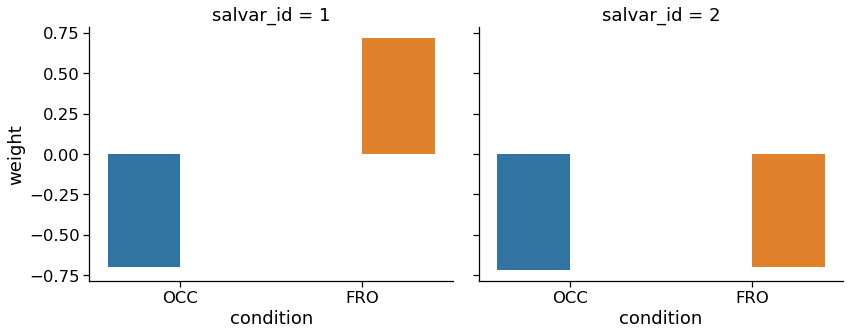

In [161]:
g = sns.catplot(x="condition", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2, hue="condition",data=y_loadings_beh_m)




In [162]:
help(pls.bootres)

Help on PLSBootResults in module pyls.structures object:

class PLSBootResults(pyls.utils.ResDict)
 |  PLSBootResults(**kwargs)
 |  
 |  Dictionary-like object containing results of PLS bootstrap resampling
 |  
 |  Attributes
 |  ----------
 |  x_weights_normed : (B, L) `numpy.ndarray`
 |      `x_weights` normalized by their standard error, obtained from bootstrap
 |      resampling (see `x_weights_stderr`)
 |  x_weights_stderr : (B, L) `numpy.ndarray`
 |      Standard error of `x_weights`, used to generate `x_weights_normed`
 |  y_loadings : (J, L) `numpy.ndarray`
 |      Covariance of features in `Y` with projected `x_scores`; not available
 |      with :func:`.meancentered_pls`
 |  y_loadings_boot : (J, L, R) `numpy.ndarray`
 |      Distribution of `y_loadings` across all bootstrap resamples; not
 |      available with :func:`.meancentered_pls`
 |  y_loadings_ci: (J, L, 2) `numpy.ndarray`
 |      Lower (..., 0) and upper (..., 1) bounds of confidence interval for
 |      `y_loading

In [175]:
pls.permres.pvals

array([1., 1.])

In [169]:
pls.bootres.contrast_ci[:,:,1]

array([[0.31633732, 0.16042898],
       [0.3071029 , 0.15847711]])

## Example from paper

In [100]:
X = [[2,5,6,1,9,1, 7, 6, 2, 1, 7, 3],
     [4,1,5,8, 8,7, 2, 8, 6, 4, 8, 2],
    [5,8,7,3, 7,1, 7, 4, 5, 1, 4, 3],
    [3,3,7,6, 1,1,10,2,2, 1, 7, 4],
    [2,3,8,7, 1,6, 9, 1, 8, 8, 1, 6],
    [1,7,3,1, 1,3, 1, 8, 1, 3, 9, 5],
    [9,0,7,1, 8,7, 4, 2, 3, 6, 2, 7],
    [8,0,6,5, 9,7, 4, 4,2,10,3,8],
    [7,7,4,5, 7,6, 7, 6, 5, 4, 8, 8]]

In [101]:
np.array(X).shape

(9, 12)

In [104]:
pls_e = meancentered_pls(X, groups=[3,3,3], seed=42)

/home/jarvis/miniconda3/envs/hmm/lib/python3.7/site-packages/pyls-0.0.1-py3.7.egg/pyls/types/meancentered.py:32: UserWarning: Cannot set mean_centering to 0 when there is only one condition. Resetting mean_centering to 1.
  warnings.warn('Cannot set mean_centering to 0 when there is only '
Running permutations:   0%|                                   | 0/5000 | 00:00<?/home/jarvis/miniconda3/envs/hmm/lib/python3.7/site-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,
Making bootstraps:   0%|                                      | 0/5000 | 00:00<?/home/jarvis/miniconda3/envs/hmm/lib/python3.7/sit

In [106]:
pls_e

PLSResults(x_weights, y_weights, x_scores, y_scores, singvals, varexp, permres, bootres, inputs)

In [107]:
pls_e.permres.pvals

array([0.03259348, 0.39612078, 0.98020396])

In [ ]:
pls_e.x_weights

## PLS THREE GROUPS

In [111]:
X_pre = np.concatenate((fraccional_occupacy_pre, mean_life_time_pre, interval_times_pre), axis=1)
X_occ = np.concatenate((fraccional_occupacy_occ_post, mean_life_time_occ_post, interval_times_occ_post), axis=1)
X_fro = np.concatenate((fraccional_occupacy_fro_post, mean_life_time_fro_post, interval_times_fro_post), axis=1)


X_pre = interval_times_pre
X_occ = interval_times_occ_post
X_fro = interval_times_fro_post

X_pre_s =StandardScaler().fit_transform(X_pre)
X_occ_s= StandardScaler().fit_transform(X_occ)
X_fro_s =StandardScaler().fit_transform(X_fro)


In [112]:
X = np.concatenate((X_pre_s,X_occ_s, X_fro_s ))
X.shape

(69, 12)

In [116]:
pls_t = meancentered_pls(X,groups=[23,23,23], seed=42,n_perm=1000)

/home/jarvis/miniconda3/envs/hmm/lib/python3.7/site-packages/pyls-0.0.1-py3.7.egg/pyls/types/meancentered.py:32: UserWarning: Cannot set mean_centering to 0 when there is only one condition. Resetting mean_centering to 1.
  warnings.warn('Cannot set mean_centering to 0 when there is only '
Running permutations:   0%|                                   | 0/1000 | 00:00<?/home/jarvis/miniconda3/envs/hmm/lib/python3.7/site-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


In [117]:
pls_t.permres.pvals

array([1., 1., 1.])

In [3]:
y = np.array([1,1,1,0,0,0])

In [5]:
y.reshape((y.shape[0],3))

ValueError: cannot reshape array of size 6 into shape (6,3)

In [16]:
np.array([list(y)]*20).T.flatten()

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0])